# Diversity Test

This notebook compares categorical index diversity in the ranked recommendations. If you want to see distance comparisons, head out to the next note. 

Number of sampled actions: 50

``` ddpg_action = ddpg_action[np.random.randint(0, 5000, 50)].detach().cpu().numpy() <- that 50 ```

K parameter for TopK ranking: 20 (changed in the query function arguments)

Next part contains A LOT of various graphs that are not grouped. If you want GROUPED comparison, go to the bottom section

In [1]:
import torch # conda install faiss-gpu cudatoolkit=10.0 -c pytorch # For CUDA10

In [2]:
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from milvus import MetricType

from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='grade3')


# == recnn ==
import sys
sys.path.append("../../")
import recnn
from recnn.data.db_con import MilvusConnection

cuda = torch.device('cuda')
tqdm.pandas()

/ssd/anaconda/envs/recnn/lib/python3.8/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
ddpg = recnn.nn.models.Actor(1290, 128, 256).to(cuda)
td3 = recnn.nn.models.Actor(1290, 128, 256).to(cuda)
ddpg.load_state_dict(torch.load('../../models/ddpg_policy.pt'))
td3.load_state_dict(torch.load('../../models/td3_policy.pt'))

<All keys matched successfully>

In [4]:
frame_size = 10
batch_size = 1
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
dirs = recnn.data.env.DataPath(
    base="../../data/",
    embeddings="embeddings/ml20_pca128.pkl",
    ratings="ml-20m/ratings.csv",
    cache="cache/frame_env.pkl", # cache will generate after you run
    use_cache=True
)
env = recnn.data.env.FrameEnv(dirs, frame_size, batch_size)
milvus_l2 = MilvusConnection(env, name="movies_L2", param={'metric_type':MetricType.L2})
milvus_ip = MilvusConnection(env, name="movies_IP", param={'metric_type': MetricType.IP})

In [5]:
test_batch = next(iter(env.test_dataloader))
state, action, reward, next_state, done = recnn.data.get_base_batch(test_batch)

# DDPG

In [6]:
ddpg_action = ddpg(state)
ddpg_action = ddpg_action[np.random.randint(0, state.size(0), 50)].detach().cpu().numpy() 

## L2: number the movie was recommended

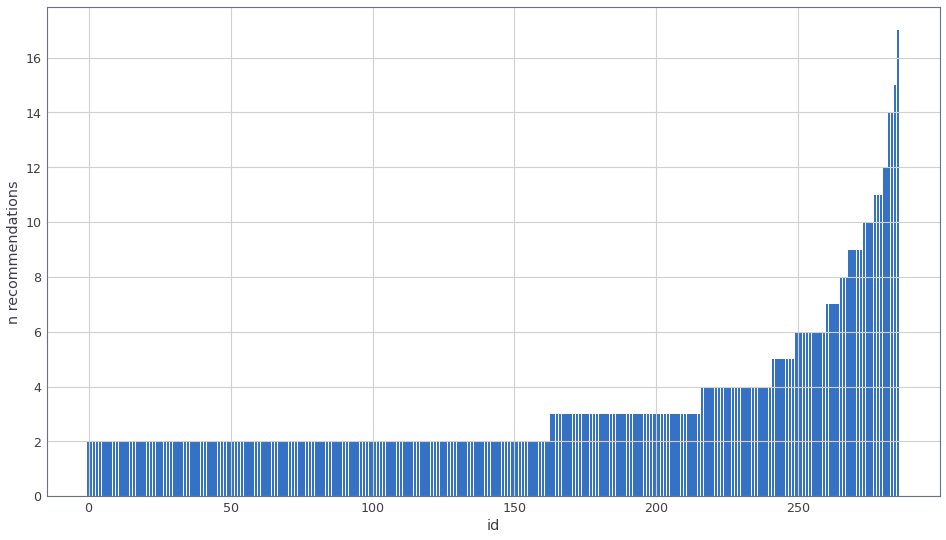

In [7]:
%matplotlib inline

topK = milvus_l2.search(ddpg_action, topk=20)
uniques, counts = np.unique(topK, return_counts=True)

plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts[counts>1])), sorted(counts[counts>1]))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")

l2_ddpg = counts

## L2: counts of n recommendations 

Text(0, 0.5, 'n counts')

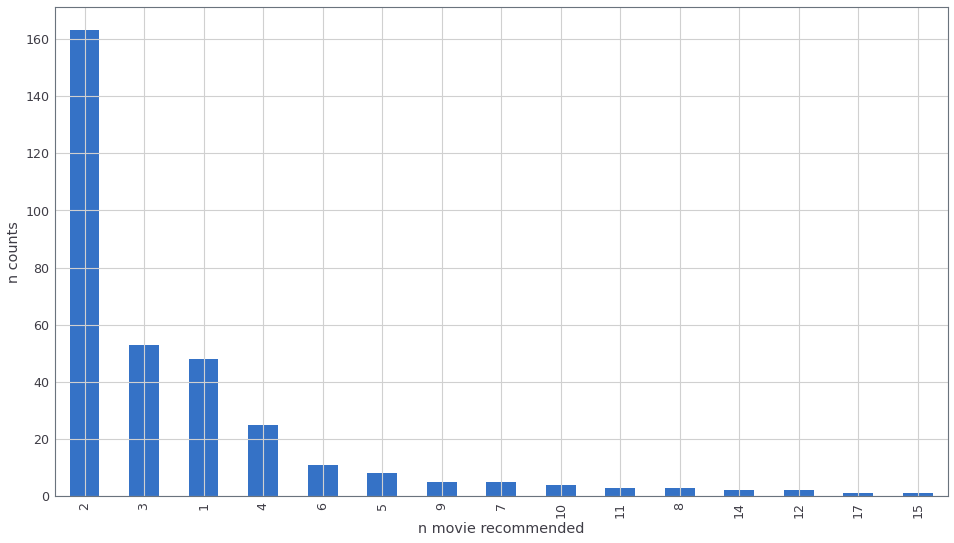

In [8]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

## InnerProduct

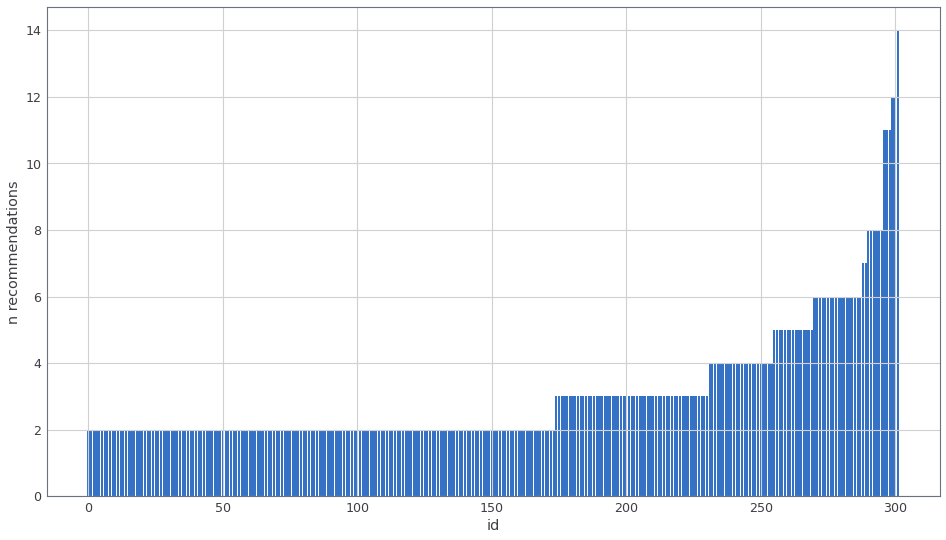

In [9]:
topK = milvus_ip.search(ddpg_action, topk=20)
uniques, counts = np.unique(topK, return_counts=True)


plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts[counts>1])), sorted(counts[counts>1]))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")

ip_ddpg = counts

Text(0, 0.5, 'n counts')

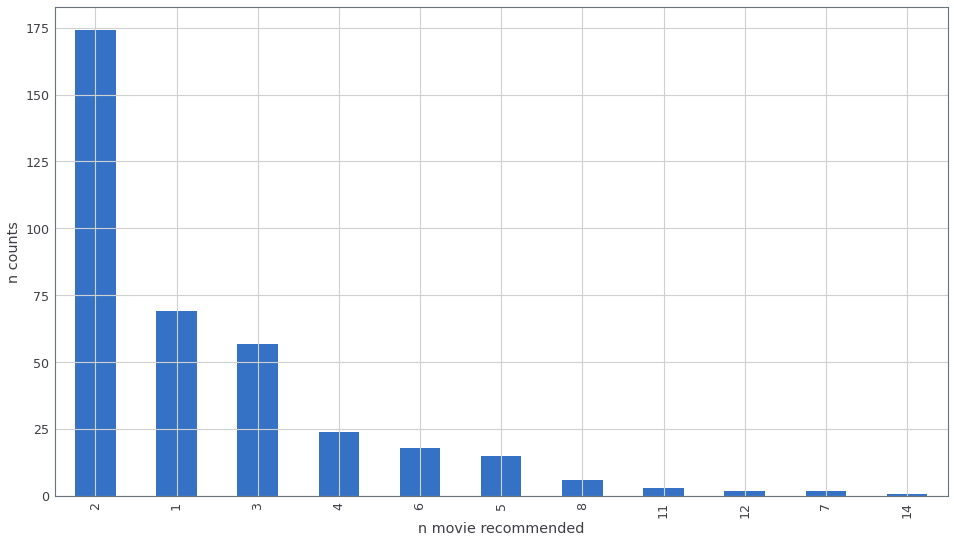

In [10]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")



# TD3

In [11]:
td3_action = td3(state)
td3_action = td3_action[np.random.randint(0, state.size(0), 50)].detach().cpu().numpy() 

## L2

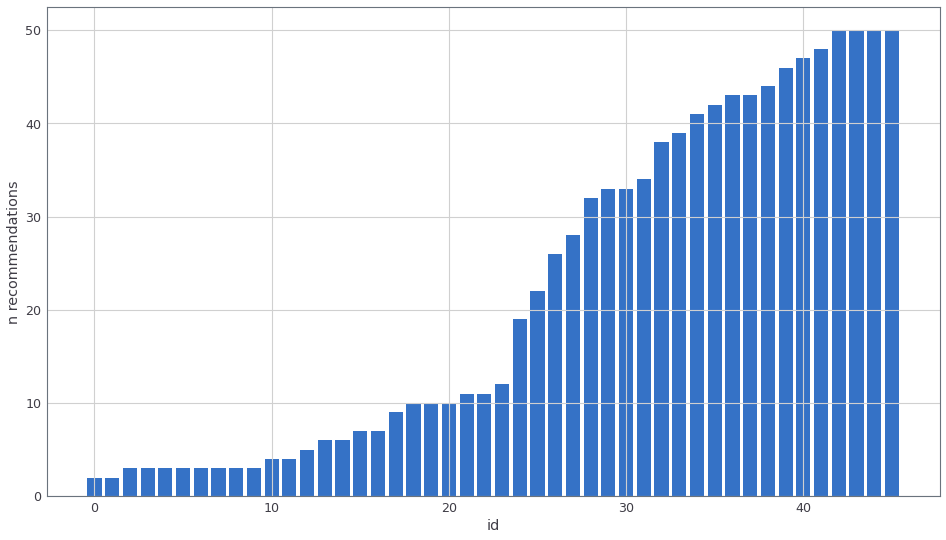

In [12]:
topK = milvus_l2.search(td3_action, topk=20)
uniques, counts = np.unique(topK, return_counts=True)


plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts[counts>1])), sorted(counts[counts>1]))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")
l2_td3 = counts

Text(0, 0.5, 'n counts')

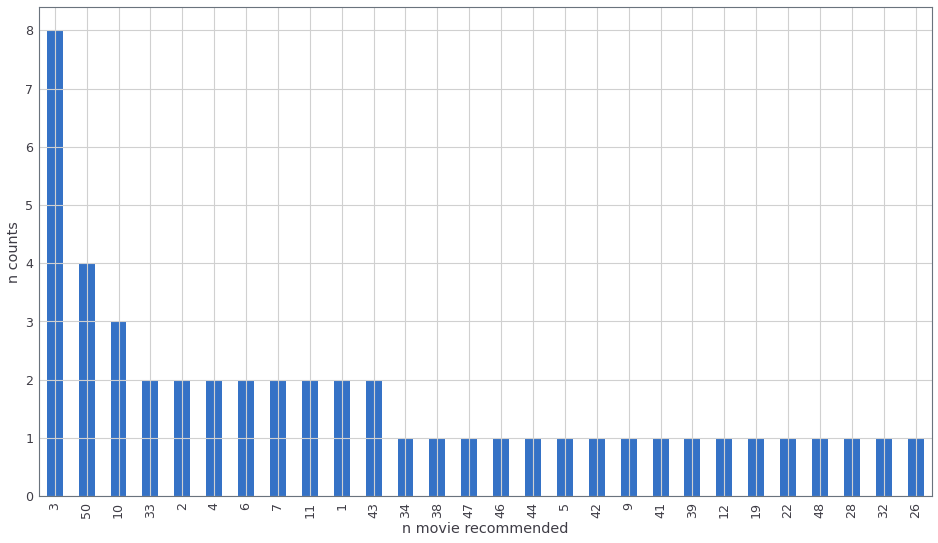

In [13]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")

# InnerProduct

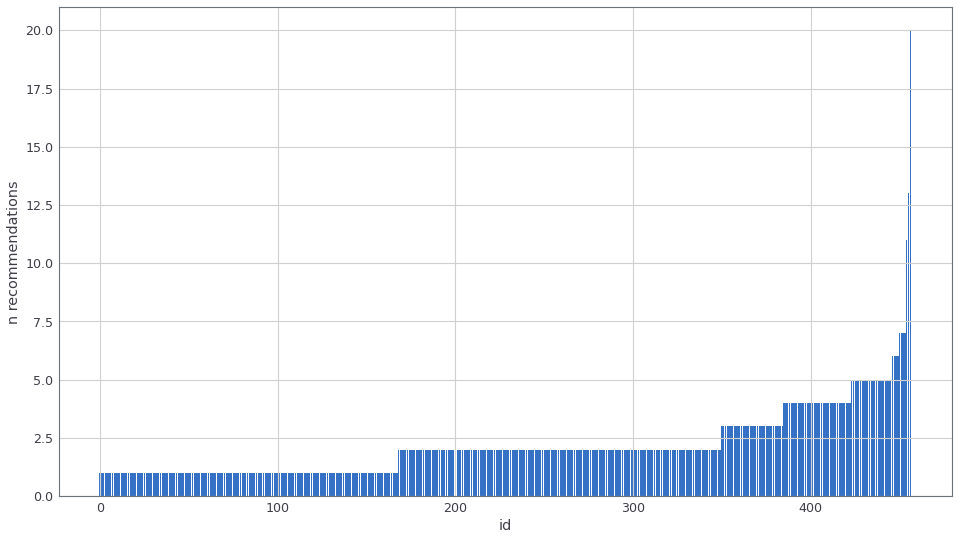

In [14]:
topK = milvus_ip.search(td3_action, topk=20)
uniques, counts = np.unique(topK, return_counts=True)

plt.figure(figsize=(16,9))
# p.s. expluding one
ax = plt.subplot()
ax.bar(range(len(counts)), sorted(counts))
ax.set_xlabel("id")
ax.set_ylabel("n recommendations")
ip_td3 = counts

Text(0, 0.5, 'n counts')

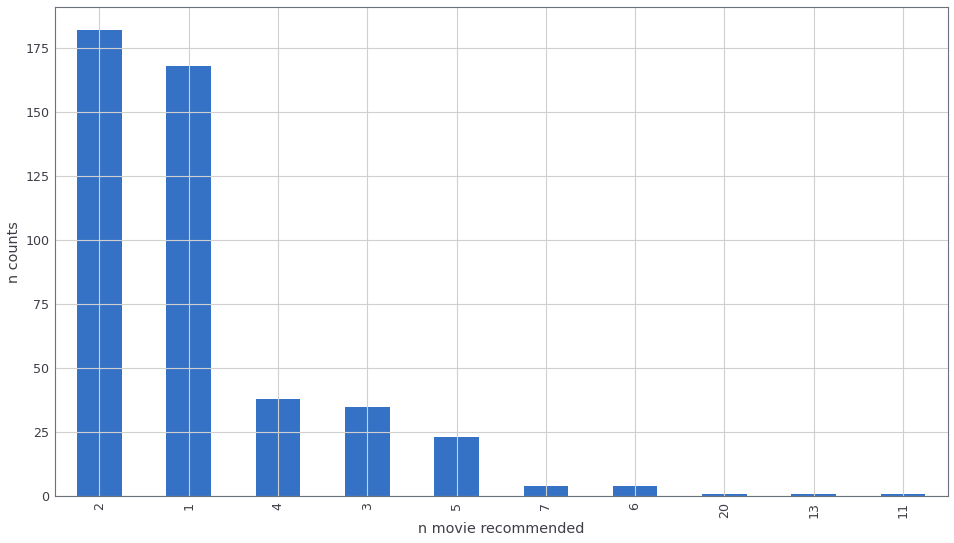

In [15]:
ax = pd.Series(counts).value_counts().plot(kind='bar', figsize=(16, 9))
ax.set_xlabel("n movie recommended")
ax.set_ylabel("n counts")



# Grouped comparison

## L2 top 30

In [16]:
def plot_comp(ddpg, td3):
    barWidth = 0.25
    r1 = np.arange(len(ddpg))[:30]
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    plt.figure(figsize=(16, 9))

    plt.bar(r1, ddpg, width=barWidth, edgecolor='white', label='ddpg')
    plt.bar(r2, td3, width=barWidth, edgecolor='white', label='td3')

    # Add xticks on the middle of the group bars
    plt.xlabel('id')
    plt.ylabel('n recommended')

    # Create legend & Show graphic
    plt.legend()
    plt.show()

In [17]:
def plot_counts(l2_ddpg, l2_td3):
    l2_ddpg_counts, l2_td3_counts =  [pd.Series(i).value_counts() for i in [l2_ddpg, l2_td3]]
    l2_ddpg_counts, l2_td3_counts = [i[i > 1] for i in [l2_ddpg_counts, l2_td3_counts]]

    unique_idx = l2_ddpg_counts.index.unique()| l2_td3_counts.index.unique()

    for arr in [l2_ddpg_counts, l2_td3_counts]:
        for i in unique_idx:
            if i not in arr:
                arr[i] = 0

    barWidth = 0.25
    r1 = np.arange(len(l2_ddpg_counts))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    plt.figure(figsize=(16, 9))

    plt.bar(r1, l2_ddpg_counts, width=barWidth, edgecolor='white', label='ddpg')
    plt.bar(r2, l2_td3_counts, width=barWidth, edgecolor='white', label='td3')

    # Add xticks on the middle of the group bars
    plt.xlabel('n recommended')
    plt.ylabel('counts')

    # Create legend & Show graphic
    plt.legend()
    plt.show()

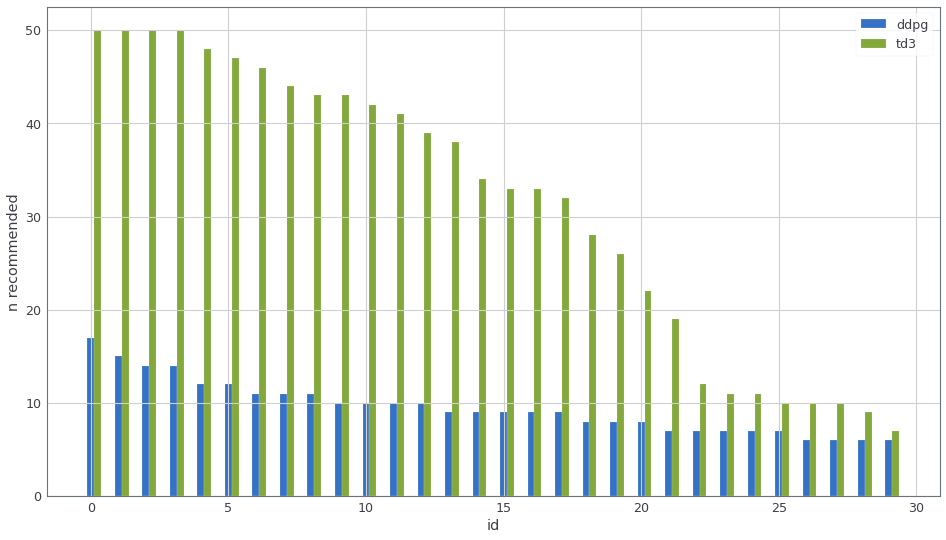

In [18]:
l2_ddpg_ = np.sort(l2_ddpg)[::-1][:30]
l2_td3_  = np.sort(l2_td3)[::-1][:30]

plot_comp(l2_ddpg_, l2_td3_)

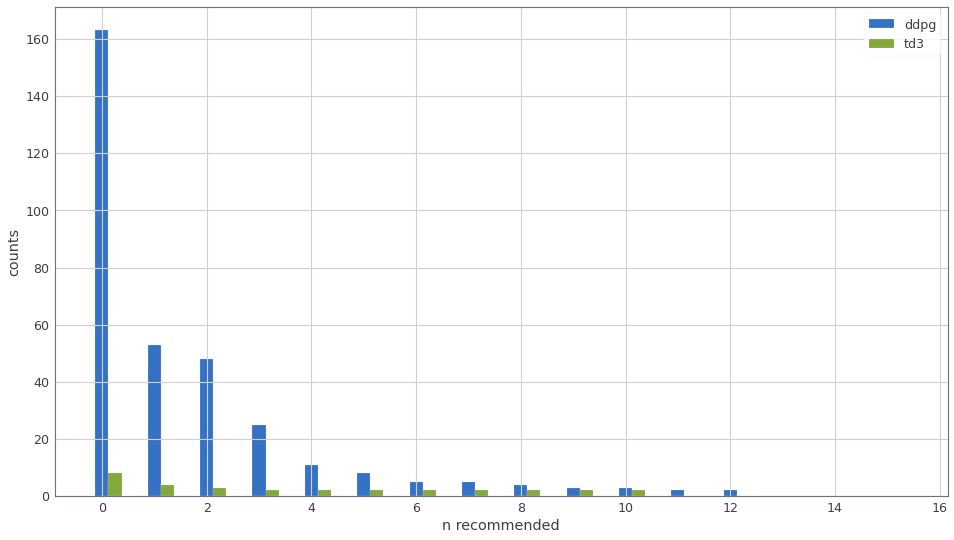

In [19]:
plot_counts(l2_ddpg, l2_td3)

## InnerProduct top 30

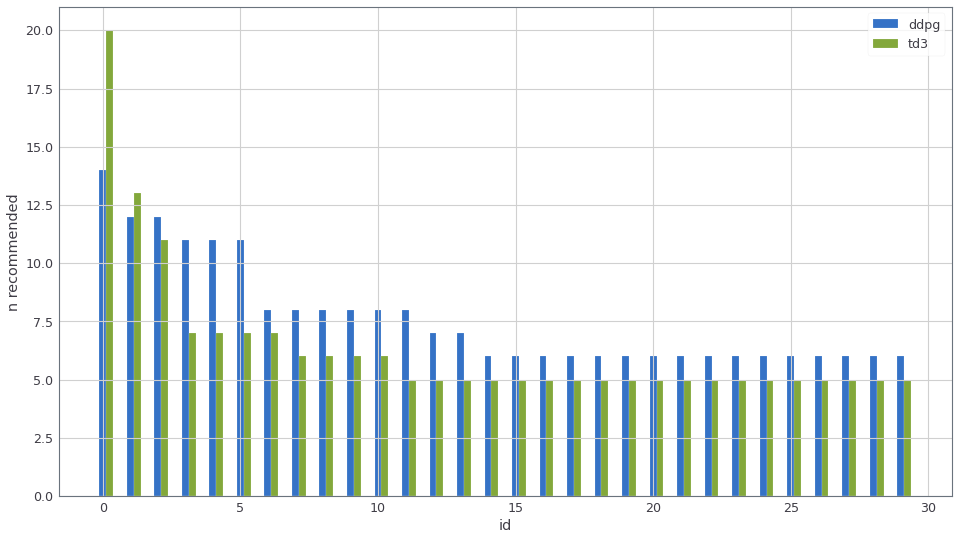

In [20]:
ip_ddpg_ = np.sort(ip_ddpg)[::-1][:30]
ip_td3_  = np.sort(ip_td3)[::-1][:30]

plot_comp(ip_ddpg_, ip_td3_)

## InnerProduct top 30-50

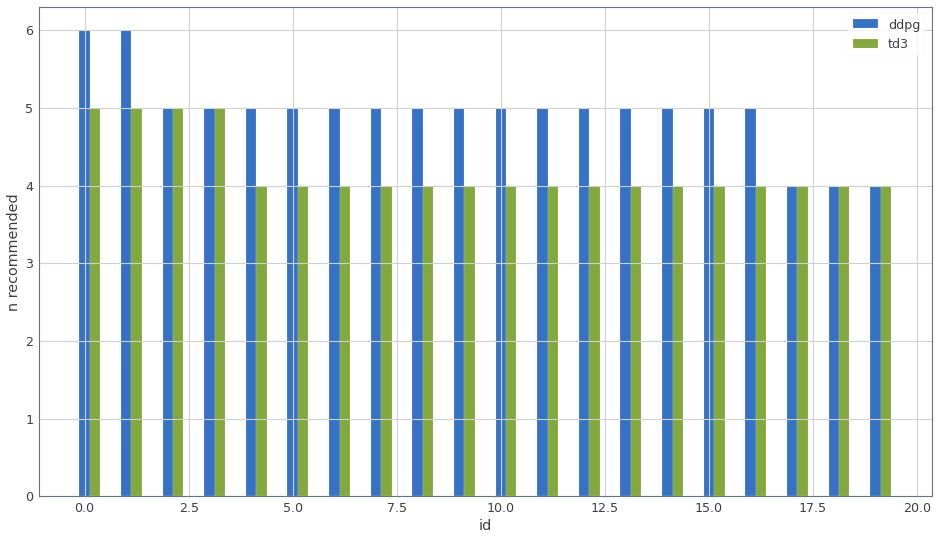

In [21]:
ip_ddpg_ = np.sort(ip_ddpg)[::-1][30:50]
ip_td3_  = np.sort(ip_td3)[::-1][30:50]

plot_comp(ip_ddpg_, ip_td3_)

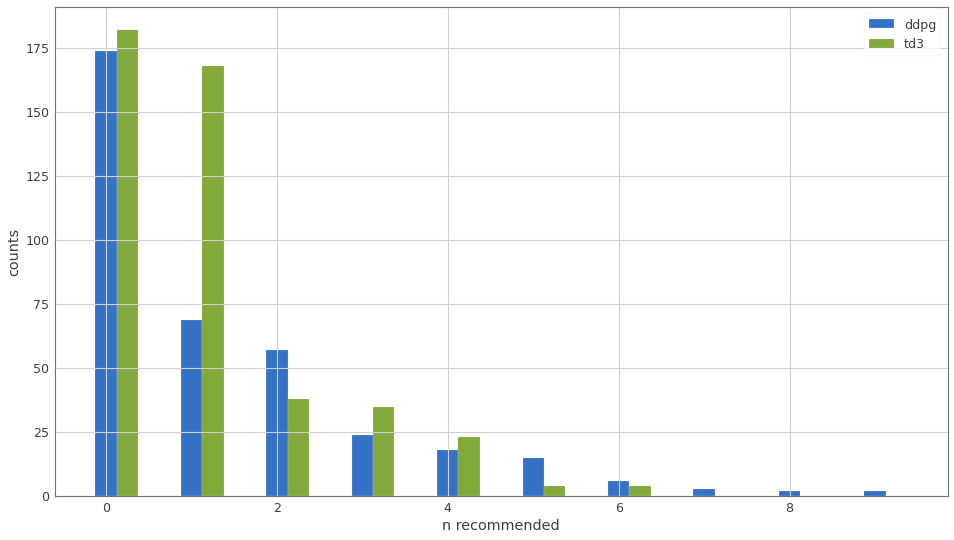

In [22]:
plot_counts(ip_ddpg, ip_td3)
